1/1 [==============================] - 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Accuracy: 1.0000
Test Accuracy: 0.8000

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.83      1.00      0.91         5
     Axar_Patel       0.75      0.75      0.75         4
 Jasprit_Bumrah       0.80      0.67      0.73         6
  Kuldeep_Yadav       1.00      1.00      1.00         6
Ravindra_Jadeja       0.50      0.40      0.44         5
    Virat_Kohli       0.80      1.00      0.89         4

       accuracy                           0.80        30
      macro avg       0.78      0.80      0.79        30
   weighted avg       0.79      0.80      0.79        30



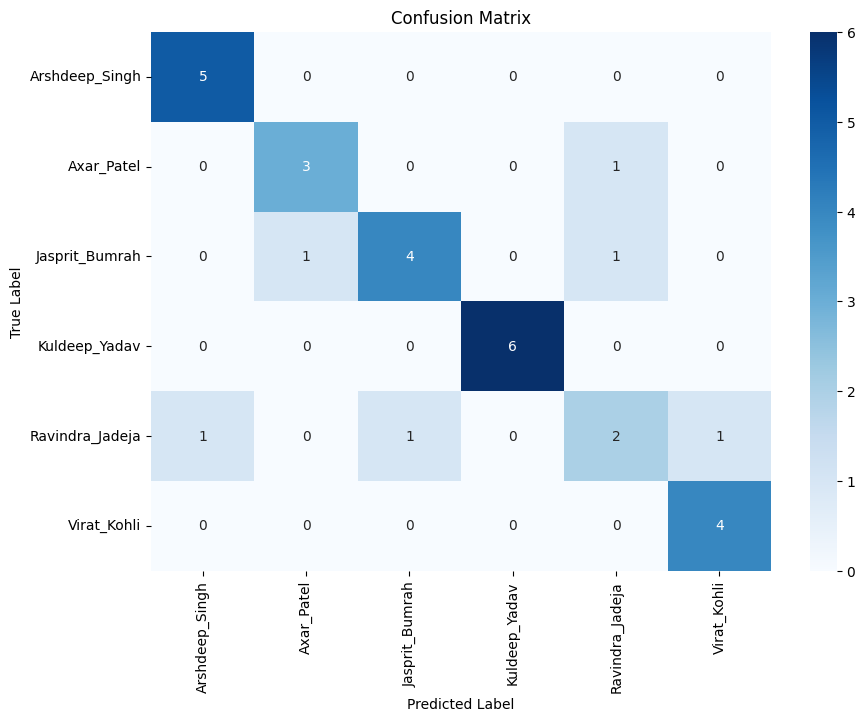

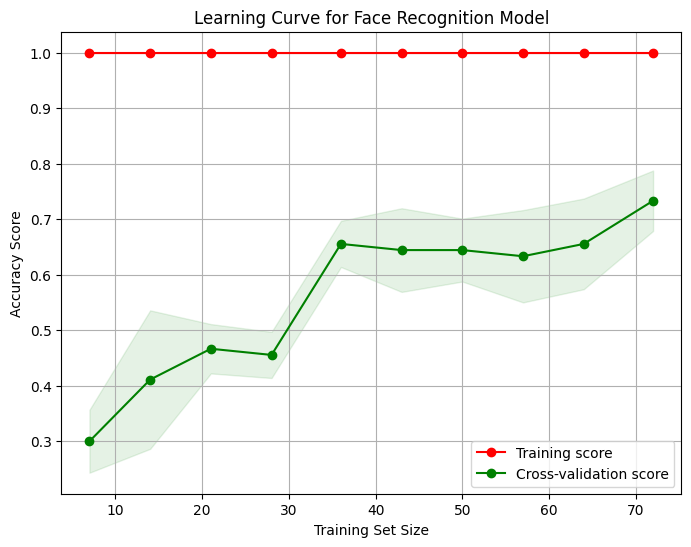

In [1]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib 
from transformers import ViTModel, ViTFeatureExtractor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN()
        self.X = []  # Initialize X attribute
        self.Y = []  # Initialize Y attribute

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.detector.detect_faces(img)
        if results:
            x, y, w, h = results[0]['box']
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        return None

    def load_faces(self, dir):
        faces = []
        for im_name in os.listdir(dir):
            if im_name.startswith('.'):  # Skip hidden files
                continue
            path = os.path.join(dir, im_name)
            if os.path.isfile(path):  # Ensure it's a file, not a directory
                try:
                    single_face = self.extract_face(path)
                    if single_face is not None:
                        faces.append(single_face)
                except Exception as e:
                    print(f"Error processing {path}: {e}")
        return faces

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            if sub_dir.startswith('.'):  # Skip hidden directories/files
                continue
            path = os.path.join(self.directory, sub_dir)
            if os.path.isdir(path):  # Ensure it's a directory
                faces = self.load_faces(path)
                self.X.extend(faces)
                self.Y.extend([sub_dir] * len(faces))
        return np.asarray(self.X), np.asarray(self.Y)
    

def get_embedding(face_img):
    inputs = feature_extractor(images=face_img, return_tensors="pt")
    outputs = model_vit(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy().flatten()  # Flatten the embedding

# Load dataset
faceloading = FACELOADING("Dataset")
X, Y = faceloading.load_classes()

# Initialize the Vision Transformer and its feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model_vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Process and embed faces using Vision Transformer
EMBEDDED_X = [get_embedding(img).flatten() for img in X]
EMBEDDED_X = np.asarray(EMBEDDED_X)

# Encode labels
encoder = LabelEncoder()
Y_enc = encoder.fit_transform(Y)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y_enc, shuffle=True, random_state=17)

# Train model
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

# Evaluate training accuracy
train_accuracy = model.score(X_train, Y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate test accuracy
test_accuracy = model.score(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
Y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Define the function to plot learning curves
def plot_learning_curves(model, X, y, title='Learning Curves'):
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy')

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    # Draw bands for standard deviation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves using the defined function
plot_learning_curves(model, X_train, Y_train, title='Learning Curve for Face Recognition Model')

# Save model and encoder
# joblib.dump(model, 'trained_model/face_recognition_model.pkl')
# joblib.dump(encoder, 'trained_model/label_encoder.pkl')

In [2]:
import cv2 as cv
import numpy as np
import os
from mtcnn.mtcnn import MTCNN
from transformers import ViTModel, ViTFeatureExtractor
import joblib

# Ensure TensorFlow logging is controlled
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load the Vision Transformer model for embeddings and the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model_vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Load the SVM model and label encoder
model = joblib.load('trained_model/face_recognition_model.pkl')
encoder = joblib.load('trained_model/label_encoder.pkl')

# Initialize MTCNN for face detection
detector = MTCNN()

# Function to get embeddings using Vision Transformer
def get_embedding(face_img):
    inputs = feature_extractor(images=face_img, return_tensors="pt")
    outputs = model_vit(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy().flatten()  # Flatten the embedding

# Select webcam;
cap = cv.VideoCapture(0) 

while cap.isOpened():
    _, frame = cap.read()
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # Detect faces in the frame
    results = detector.detect_faces(rgb_img)
    for result in results:
        x, y, w, h = result['box']
        face = rgb_img[y:y+h, x:x+w]
        face = cv.resize(face, (160, 160))

        # Generate embedding for the detected face
        embedding = get_embedding(face)
        embedding = np.expand_dims(embedding, axis=0)

        # Predict the identity of the face
        ypred = model.predict(embedding)
        if model.predict_proba(embedding).max() > 0.5:  # Confidence threshold
            final_name = encoder.inverse_transform(ypred)[0]
        else:
            final_name = "Unknown"

        # Display the identity and a bounding box around the face
        cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
        cv.putText(frame, str(final_name), (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv.LINE_AA)

    cv.imshow("Face Recognition", frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 0s 87ms/step


2024-07-03 14:27:25.870 Python[83678:3633202] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 [==============================] - 0s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

: 